In [34]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC, kspaceFirstOrder2DG
from kwave.utils import *
from kwave.utils import dotdict
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load in 3D Vessel Data

In [35]:
data_path='/mnt/WD6TB/tianaoli/skinVessel/'
data = scio.loadmat(os.path.join(data_path, '899.mat'))
skin = np.array(data['skin'], dtype=float)
print(skin.shape)

(128, 128, 64)


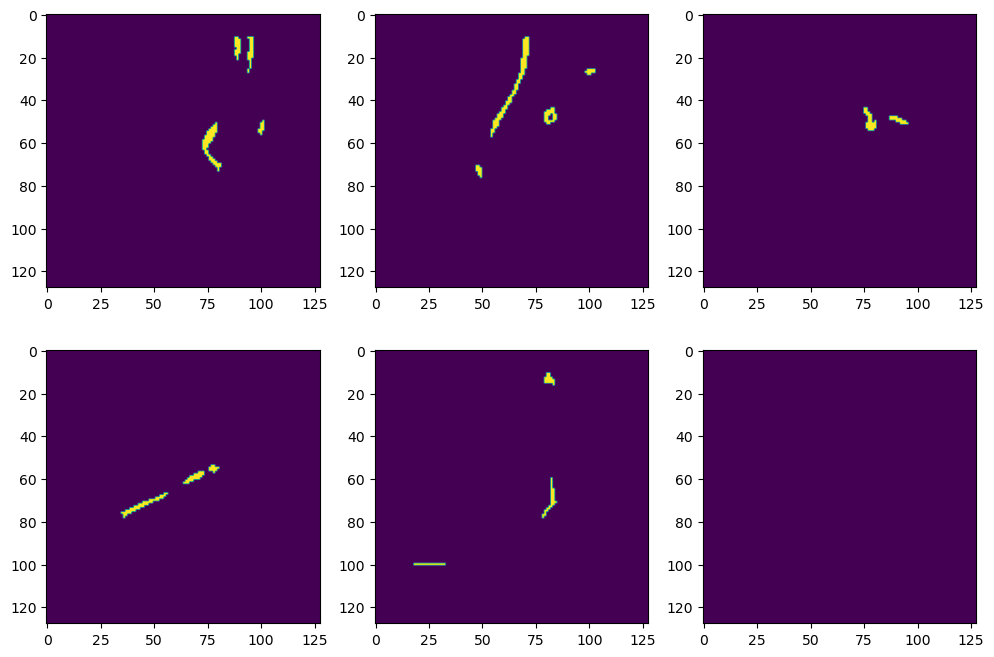

In [36]:
fig = plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(skin[:,:,5*i+11])

In [37]:
gt = skin[:,:,16]
gt -= gt.mean()

In [38]:
pathname = gettempdir()

# Create the computational grid.
PML_size = 20               # size of the PML in grid points
Nx = 128                   # number of grid points in the x direction
Ny = 128                   # number of grid points in the y direction
dx = 2.5e-4                 # grid point spacing in the x direction [m]
dy = 2.5e-4                 # grid point spacing in the y direction [m]
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

radius = 5e-3 # m
num_points = 256
center_pos = [0, 0]
arc_angle = 2 * np.pi

# Define the properties of the propagation medium.
medium = kWaveMedium(sound_speed=1500)

In [39]:
# gt = np.zeros((Nx, Ny))

### K-wave Forward Simulation

In [40]:
source = kSource()
source.p0 = gt

# smooth the initial pressure distribution and restore the magnitude
source.p0 = smooth(source.p0, True)

# define a binary line sensor
# sensor_mask = np.zeros((Nx, Ny))
# sensor_mask[0, :] = 1
# sensor = kSensor(sensor_mask)

cart_sensor_mask = makeCartCircle(radius, num_points, center_pos, arc_angle)
# assign to sensor structure
sensor_mask = cart_sensor_mask
sensor = kSensor(cart_sensor_mask)

# create the time array
kgrid.makeTime(medium.sound_speed)

# set the input arguements: force the PML to be outside the computational
# grid switch off p0 smoothing within kspaceFirstOrder2D
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False
}

# run the simulation
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 27-Feb-2023-05-46-11
Running k-Wave simulation...
  start time: 27-Feb-2023-05-46-11
  reference sound speed:  1500 m/s
  reference sound speed:  1500.0 m/s
  cart2grid: 144.0 Cartesian points mapped to overlapping grid points
  dt:  50.0ns , t_end: 30.15us , time steps: 604
  input grid size: 128 by 128 grid points (32.0 by 32.0 m)
  maximum supported frequency:  3.0M Hz
  expanding computational grid...
  computational grid size: 168 by 168 grid points
  precomputation completed in  0.0025209011510014534 s
  saving input files to disk...
  completed in  0.3281022347509861 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                (112, 604)


Text(0, 0.5, 'Detector')

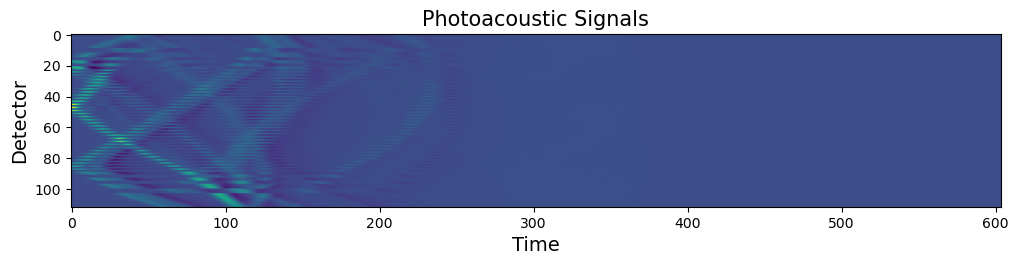

In [41]:
plt.figure(figsize=(12,6))
plt.imshow(sensor_data)
plt.title('Photoacoustic Signals', fontsize=15)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Detector', fontsize=14)

### K-wave Time Reversal

In [42]:
# assign to the source structure
source = kSource()
source.p0 = np.zeros((Nx,Ny))

# sensor_mask = np.zeros((Nx, Ny))
# sensor_mask[1, :] = 1
# sensor = kSensor(sensor_mask)
cart_sensor_mask = makeCartCircle(radius, num_points, center_pos, arc_angle)
# assign to sensor structure
sensor_mask = cart_sensor_mask
sensor = kSensor(cart_sensor_mask)

# create the time array
kgrid.makeTime(medium.sound_speed)
sensor.time_reversal_boundary_data = sensor_data

# set the input arguements: force the PML to be outside the computational
# grid switch off p0 smoothing within kspaceFirstOrder2D
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'input.h5'),
    'SaveToDiskExit': False
}
recon = kspaceFirstOrder2DG(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

  start time: 27-Feb-2023-05-46-15
Running k-Wave simulation...
  start time: 27-Feb-2023-05-46-15
  reference sound speed:  1500 m/s
  reference sound speed:  1500.0 m/s


ValueError: source.p_mask must be the same size as the computational grid.

Text(0.5, 1.0, 'Ground Truth')

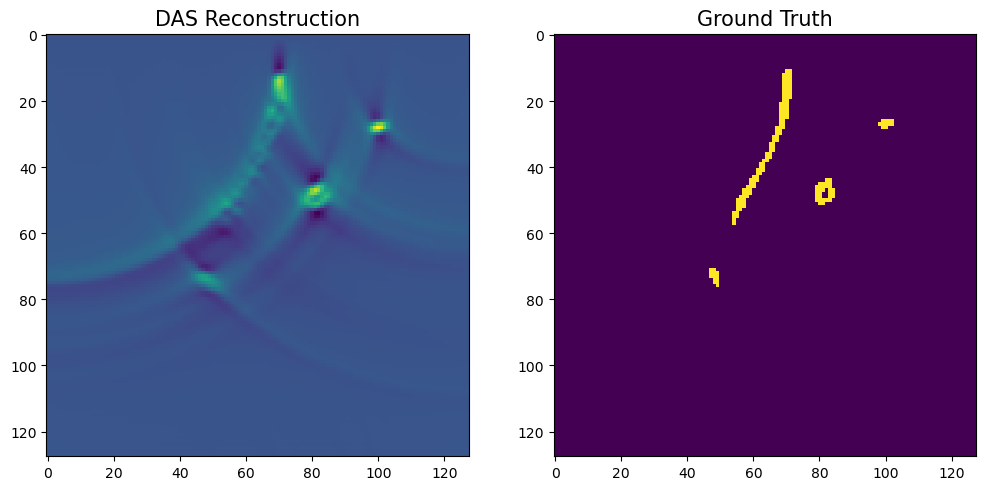

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(recon[10:-10,10:-10])
plt.title('DAS Reconstruction', fontsize=15)

plt.subplot(1,2,2)
plt.imshow(gt)
plt.title('Ground Truth', fontsize=15)